In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import time
from datetime import datetime
from scipy import integrate, optimize
import warnings
warnings.filterwarnings('ignore')
import matplotlib.ticker as ticker
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

## 1.0 Data Cleaning

In [2]:
rawdf = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df_global = rawdf.loc[:,:'12/10/20'] #extract date up till 12/10/20
df_global.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,12/1/20,12/2/20,12/3/20,12/4/20,12/5/20,12/6/20,12/7/20,12/8/20,12/9/20,12/10/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,46516,46718,46837,46837,47072,47306,47516,47716,47851,48053
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,39014,39719,40501,41302,42148,42988,43683,44436,45188,46061
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,84152,85084,85927,86730,87502,88252,88825,89416,90014,90579
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,6790,6842,6904,6955,7005,7050,7084,7127,7162,7190
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,15251,15319,15361,15493,15536,15591,15648,15729,15804,15925


In [3]:
df_canada = df_global[df_global['Country/Region']=='Canada']
df_canada.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,12/1/20,12/2/20,12/3/20,12/4/20,12/5/20,12/6/20,12/7/20,12/8/20,12/9/20,12/10/20
39,Alberta,Canada,53.9333,-116.5765,0,0,0,0,0,0,...,59484,61169,63023,64851,66730,68566,70301,72028,73488,75054
40,British Columbia,Canada,53.7267,-127.6476,0,0,0,0,0,0,...,33894,34728,35422,36132,36132,36132,38152,38718,39337,40060
41,Diamond Princess,Canada,0.0000,0.0000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42,Grand Princess,Canada,0.0000,0.0000,0,0,0,0,0,0,...,13,13,13,13,13,13,13,13,13,13
43,Manitoba,Canada,53.7609,-98.8139,0,0,0,0,0,0,...,17107,17384,17751,18069,18423,18806,19131,19376,19655,19947


### We choose Canada as our analysis object, so we sum up cases of all provinces in Canada

In [4]:
#calculate total confirmed cases in Canada
df_canada = df_canada.loc[:,'1/22/20':]
df_canada.loc["sum"] =df_canada.apply(lambda x:x.sum()) 

In [5]:
df_canada = df_canada.loc[["sum"]]
df_canada

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,12/1/20,12/2/20,12/3/20,12/4/20,12/5/20,12/6/20,12/7/20,12/8/20,12/9/20,12/10/20
sum,0,0,0,0,1,1,2,2,2,4,...,387052,393506,399770,406189,412543,418848,426572,432743,439142,445828


### we found that the first case occurred on 1/26/20, so we choose that date as the beginning of our time series

In [6]:
df_canada = df_canada.loc[:,'1/26/20':]
df_canada

,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,...,12/1/20,12/2/20,12/3/20,12/4/20,12/5/20,12/6/20,12/7/20,12/8/20,12/9/20,12/10/20
sum,1,1,2,2,2,4,4,4,4,4,...,387052,393506,399770,406189,412543,418848,426572,432743,439142,445828


## 2.0 EDA

### Plot cumulative cases in Canada with respect to time

Text(0, 0.5, 'Case Count')

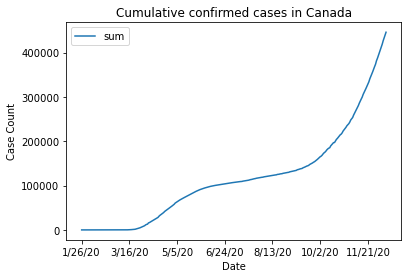

In [7]:
df_canada.transpose().plot()
plt.title('Cumulative confirmed cases in Canada')
plt.xlabel('Date')
plt.ylabel('Case Count')

### Plot daily cases in Canada with respect to time

Text(0, 0.5, 'Case Count')

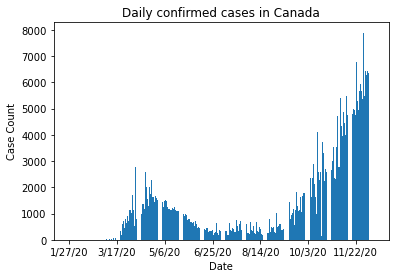

In [8]:
daily_case = df_canada.transpose().diff(axis=0)
fig, ax = plt.subplots(1,1)
ax.bar(daily_case.index[1:], daily_case.values.reshape(1,-1)[0][1:])
ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
plt.title('Daily confirmed cases in Canada')
plt.xlabel('Date')
plt.ylabel('Case Count')

### 

### Visualize the second dataset

### This dataset demonstrates social distancing metrics. There are two metrics to measue social distancing: desktop DAU and mean active hours per user. The deviation is described as a proportion of the actual, thus the computation would be (actual – forecast) / actual, a value of 0 indicates no deviation while more extreme positive or negative values indicate unexpectedly high or low values respectively.

In [9]:
df_sc = pd.read_csv('Anomaly Data - Sheet1.csv')
df_sc.head()

,date,metric,deviation,ci_deviation,geography
0,2020-10-01,desktop_dau,0.065025,0.752580,ES:MD:M:Madrid
1,2020-10-01,desktop_dau,0.126209,1.525795,BD:C:13:Dhaka
2,2020-10-01,desktop_dau,0.030673,0.340910,ES:CT:B:Barcelona
3,2020-10-01,desktop_dau,0.002997,0.040450,FR:IDF:75:Paris
4,2020-10-01,desktop_dau,0.056077,0.697916,IT:62:RM:Rome


In [10]:
df_ca = df_sc[df_sc['geography']=='CA']
df_ca.head()

,date,metric,deviation,ci_deviation,geography
90,2020-10-01,desktop_dau,0.069753,1.260972,CA
186,2020-10-01,mean_active_hours_per_client,0.055159,0.476424,CA
64855,2020-01-31,desktop_dau,-0.002618,-0.079391,CA
64856,2020-02-01,desktop_dau,0.023520,0.614040,CA
64857,2020-02-02,desktop_dau,0.024545,0.629664,CA


In [11]:
df_ca_dau = df_ca[df_ca['metric']=='desktop_dau']
df_ca_dau.head()

,date,metric,deviation,ci_deviation,geography
90,2020-10-01,desktop_dau,0.069753,1.260972,CA
64855,2020-01-31,desktop_dau,-0.002618,-0.079391,CA
64856,2020-02-01,desktop_dau,0.023520,0.614040,CA
64857,2020-02-02,desktop_dau,0.024545,0.629664,CA
64858,2020-02-03,desktop_dau,0.026588,0.766775,CA


#### Plot Desktop DAU Deviation in Canada from 2020-01-31 to 2020-05-05

Text(0, 0.5, 'Deviation')

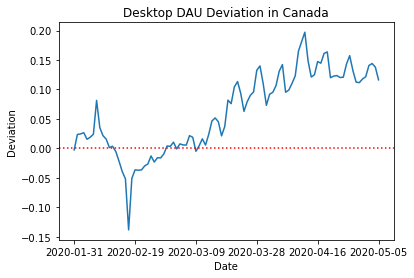

In [12]:
fig, ax = plt.subplots(1,1)
ax.plot(df_ca_dau.date[1:], df_ca_dau.deviation[1:])
ax.xaxis.set_major_locator(ticker.MultipleLocator(19))
plt.axhline(y=0,ls=":",c="r")
plt.title('Desktop DAU Deviation in Canada')
plt.xlabel('Date')
plt.ylabel('Deviation')

In [13]:
df_ca_mah = df_ca[df_ca['metric']=='mean_active_hours_per_client']
df_ca_mah.head()

,date,metric,deviation,ci_deviation,geography
186,2020-10-01,mean_active_hours_per_client,0.055159,0.476424,CA
139398,2020-01-31,mean_active_hours_per_client,-0.017431,-0.240401,CA
139399,2020-02-01,mean_active_hours_per_client,-0.015770,-0.228415,CA
139400,2020-02-02,mean_active_hours_per_client,-0.088493,-1.367709,CA
139401,2020-02-03,mean_active_hours_per_client,-0.118829,-1.574804,CA


Text(0, 0.5, 'Deviation')

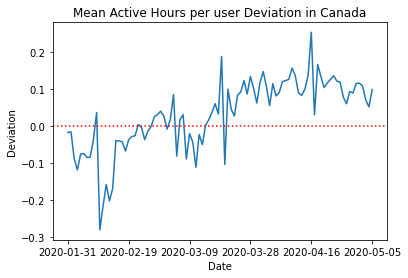

In [14]:
fig, ax = plt.subplots(1,1)
ax.plot(df_ca_mah.date[1:], df_ca_mah.deviation[1:])
ax.xaxis.set_major_locator(ticker.MultipleLocator(19))
plt.axhline(y=0,ls=":",c="r")
plt.title('Mean Active Hours per user Deviation in Canada')
plt.xlabel('Date')
plt.ylabel('Deviation')

### we can see from the mid of March to the begining of May, there is a significant increase in desktop DAU deviation, which represents the implementation of social distancing policy. Similarly, mean active hours per user exhibits relatively higher positive deviation during the same period, meaning that people used desktop for longer time and kept social distance.

## 3.0 Model Fitting

### SIR model is a simple mathematical model to understand outbreak of infectious diseases. Here we use SIR to model the spread of covid 19. There are 3 parts in SIR model, listed as below:
### S: Susceptible (=Total population - Confirmed cases)
### I: Infected (=Confirmed - Recovered - Deaths)
### R: Recovered or fatal (=Recovered + Deaths)

In [15]:
#define SIR
#beta: contact rate, gamma: recovery rate
def sir(y, x, beta, gamma):
    sus = -beta * y[0] * y[1] / N
    inf = beta*y[0]*y[1]/N-gamma*y[1]
    rec = gamma * y[1]
    return sus, inf, rec

In [16]:
N = 3.76e7 # total population in Canada
inf0 = 1 # initial number of infected people is 1
rec0 = 0.0 # initial number of recovery people
sus0 = N - inf0 - rec0# initial number of suspectible people

ydata = df_canada.transpose().values.reshape(1,-1)[0] #actual confirmed cases
xdata = np.arange(1, len(ydata)+1)

### First we perform curve fit on cumulative confirmed cases in Canada

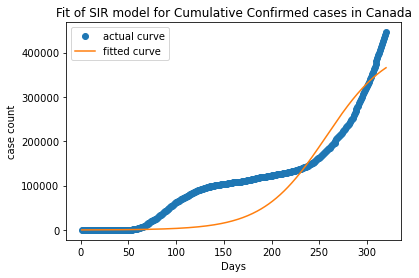

Optimal parameters: beta = 5.415242985848146  and gamma =  5.384937077733777


In [17]:
#model fit
population = float(3.76e7)
country_df = pd.DataFrame()
country_df['ConfirmedCases'] = df_canada.iloc[:,:].transpose()['sum'] #cumulative confirmed cases

country_df['day_count'] = list(range(1,len(country_df)+1))
y = [i for i in country_df.ConfirmedCases]
x = country_df.day_count
y = np.array(y, dtype=float)
x = np.array(x, dtype=float)

N = population
inf0 = 1
sus0 = N - inf0
rec0 = 0

def fit_odeint(x, beta, gamma):
    ## add I and R to get total confirm cases
    return integrate.odeint(sir, (sus0, inf0, rec0), x, args=(beta, gamma))[:,1]+integrate.odeint(sir, (sus0, inf0, rec0), x, args=(beta, gamma))[:,2]
    
popt, pcov = optimize.curve_fit(fit_odeint, x, y)
fitted = fit_odeint(x, *popt)

plt.plot(x, y, 'o',label = 'actual curve')
plt.plot(x, fitted,label = 'fitted curve')
plt.title("Fit of SIR model for Cumulative Confirmed cases in Canada")
plt.ylabel("case count")
plt.xlabel("Days")
plt.legend()
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])

### We can see the fit is very bad, with a large segment of the fitted curve under the actual curve. Besides, beta and gamma values are too large, which seems unrealistic. But we can still consider beta over gamma ratio as a reference to build different cases. Here the optimal beta and gamma leads to a ratio of 1.005.

### Plot SIR model for the worst case
### We assume beta over gamma ratio (R0) to be 5 to build the worst case

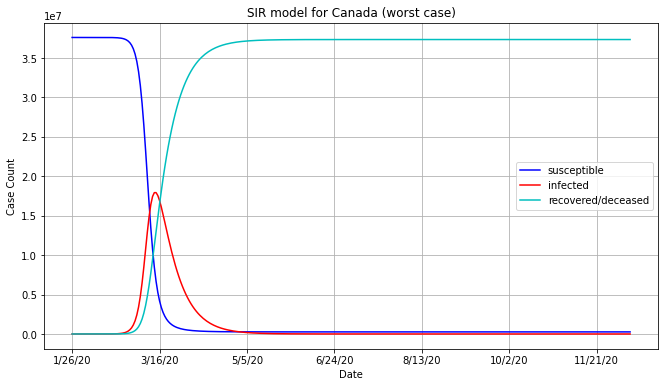

In [18]:
#Worst Case
beta = 0.5 #high contact rate, no social distancing
gamma = 0.1 #low recovery rate, distressed medical systems
y0 = (sus0,inf0,rec0)
sus_w,inf_w,rec_w = integrate.odeint(sir,y0,xdata,args=(beta,gamma)).T # predicted S,I,R values

fig = plt.figure(figsize=(11,6))
ax = fig.add_subplot(111)
date = df_canada.columns
ax.plot(date,sus_w, 'b', label='susceptible');
ax.plot(date,inf_w, 'r', label='infected');
ax.plot(date,rec_w, 'c', label='recovered/deceased')
ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
ax.legend(loc='best')
plt.title('SIR model for Canada (worst case)')
plt.ylabel("Case Count")
plt.xlabel("Date")
ax.grid(True)
plt.show()

### Plot the cumulative confirmed cases for the worst case

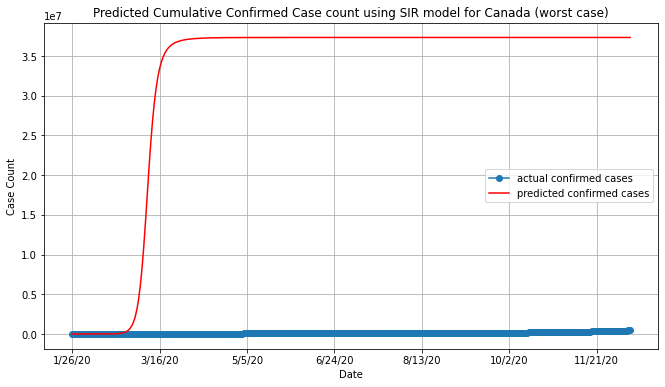

predicted cases on 12/10/20: 37337659.04715868
actual cases on 12/10/20: 445828


In [19]:
confirm_worst = inf_w+rec_w # total confirmed cases
fig = plt.figure(figsize=(11,6))
ax = fig.add_subplot(111)
date = df_canada.columns
ax.plot(date,ydata, marker='o', label='actual confirmed cases');
ax.plot(date,confirm_worst, 'r', label='predicted confirmed cases');
ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
ax.legend(loc='best')
#ax.set_ylim([0, 100000])
plt.title('Predicted Cumulative Confirmed Case count using SIR model for Canada (worst case)')
plt.ylabel("Case Count")
plt.xlabel("Date")
ax.grid(True)
plt.show()
print('predicted cases on 12/10/20: {}'.format(confirm_worst[-1]))
print('actual cases on 12/10/20: {}'.format(ydata[-1]))

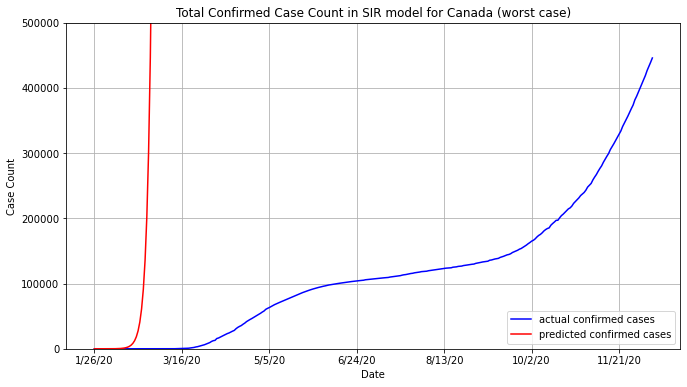

In [20]:
#zoom in to see the trend clearly
confirm_worst = inf_w+rec_w # total confirmed cases
fig = plt.figure(figsize=(11,6))
ax = fig.add_subplot(111)
date = df_canada.columns
ax.plot(date,ydata, 'b', label='actual confirmed cases');
ax.plot(date,confirm_worst, 'r', label='predicted confirmed cases');
ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
ax.legend(loc='best')
ax.set_ylim([0, 500000])
plt.title('Total Confirmed Case Count in SIR model for Canada (worst case)')
plt.ylabel("Case Count")
plt.xlabel("Date")
ax.grid(True)
plt.show()

### In the worst case, we assume a high beta over gamma ratio, it means the government took no action, people did not stay at home, did not follow social distancing and did not wear mask, and the medical system reached limit and was very distressed, then the predicted curve would be significant higher than the actual curve, and it would reach plateau at the begining of May since almost all the population in Canda were infected.

### Plot SIR model for the best case
### We assume beta = 0.2 and gamma = 0.17 (so that R0 is close to 1) to build the best case

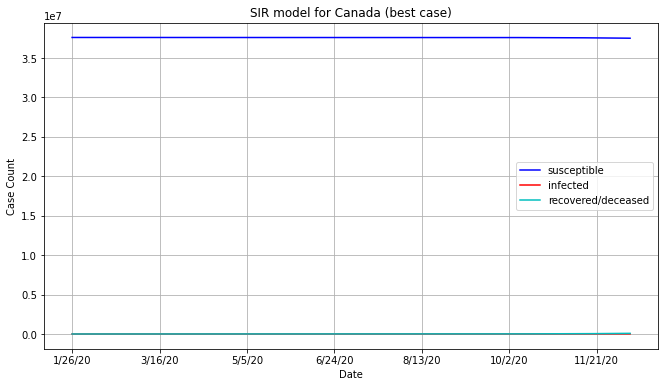

In [21]:
#best case
beta = 0.2 #low contact rate, with social distancing
gamma = 0.17 #high recovery rate, better medical systems
y0 = (sus0,inf0,rec0)
sus_b,inf_b,rec_b = integrate.odeint(sir,y0,xdata,args=(beta,gamma)).T # predicted S,I,R values

fig = plt.figure(figsize=(11,6))
ax = fig.add_subplot(111)
date = df_canada.columns
ax.plot(date,sus_b, 'b', label='susceptible');
ax.plot(date,inf_b, 'r', label='infected');
ax.plot(date,rec_b, 'c', label='recovered/deceased')
ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
ax.legend(loc='best')
#ax.set_ylim([0, 10000])
plt.title('SIR model for Canada (best case)')
plt.ylabel("Case Count")
plt.xlabel("Date")
ax.grid(True)
plt.show()

### we can see all of S, I, and R curves are nearly a horizontal line (I & R are overlapped), indicating a low confirmed cases number.

### Plot the cumulative confirmed cases for the best case

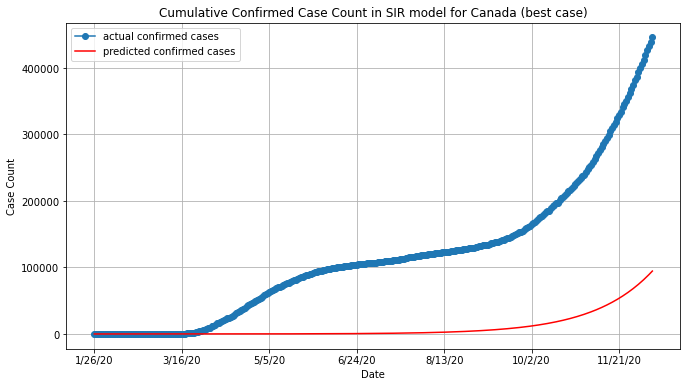

predicted cases on 12/10/20: 94597.04912877541
actual cases on 12/10/20: 445828


In [22]:
confirm_best = inf_b+rec_b # total confirmed cases
fig = plt.figure(figsize=(11,6))
ax = fig.add_subplot(111)
date = df_canada.columns
ax.plot(date,ydata,marker='o', label='actual confirmed cases');
ax.plot(date,confirm_best,'r',label='predicted confirmed cases');
ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
ax.legend(loc='best')
#ax.set_xlim([date(2020, 2, 15),date(2020, 6, 15)])
#ax.set_ylim([0, 100000])
plt.title('Cumulative Confirmed Case Count in SIR model for Canada (best case)')
plt.ylabel("Case Count")
plt.xlabel("Date")
ax.grid(True)
plt.show()
print('predicted cases on 12/10/20: {}'.format(confirm_best[-1]))
print('actual cases on 12/10/20: {}'.format(ydata[-1]))

### In the best case, we assume a low beta over gamma ratio, it means the government imposed strict policies, and people stayed at home, followed social distancing order and wore mask, and the medical system was better, then the predicted curve would go up very slowly and significantly below the actual curve. The predicted case count is less than a quarter of the actual case count.

### Plot the cumulative confirmed cases for the base-case in between best and worst case

### We use the combination of best and worst cases to build the base-case

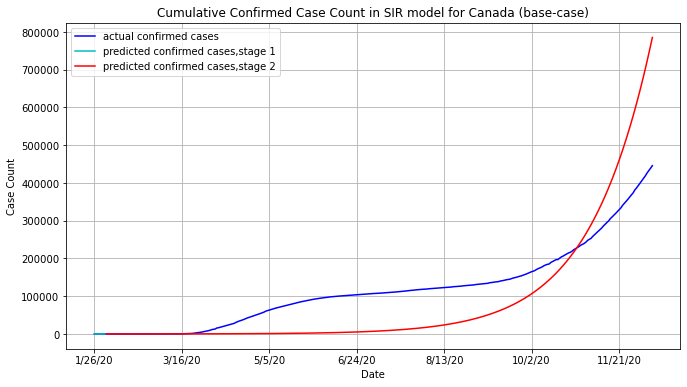

predicted cases on 12/10/20: 785374.5182919966
actual cases on 12/10/20: 445828


In [23]:
#base-case in between worst and best cases

#stage 1, for the first 7 days, government did nothing
beta1 = 0.5 # high contact rate, no social distancing
gamma1 = 0.1 # low recovery rate, distressed medical system
y0 = (sus0,inf0,rec0)
sus1,inf1,rec1 = integrate.odeint(sir,y0,xdata[:7],args=(beta1,gamma1)).T # predicted S,I,R values

#stage 2, after 7 days, government implemented strong social distancing policies
beta2 = 0.2 # lower contact rate, with strong social distancing
gamma2 = 0.17 # higher recovery rate, better medical systems
y0 = (sus1[-1],inf1[-1],rec1[-1])
sus2,inf2,rec2 = integrate.odeint(sir,y0,xdata[7:],args=(beta2,gamma2)).T # predicted S,I,R values

confirm_base1 = inf1+rec1 #confirmed case for stage1
confirm_base2 = inf2+rec2 #confirmed case for stage2
fig = plt.figure(figsize=(11,6))
ax = fig.add_subplot(111)
date = df_canada.columns
ax.plot(date,ydata,'b',label='actual confirmed cases');
ax.plot(date[:7],confirm_base1, 'c', label='predicted confirmed cases,stage 1');
ax.plot(date[7:],confirm_base2, 'r', label='predicted confirmed cases,stage 2');
ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
ax.legend(loc='best')
#ax.set_ylim([0, 1000])
plt.title('Cumulative Confirmed Case Count in SIR model for Canada (base-case)')
plt.ylabel("Case Count")
plt.xlabel("Date")
ax.grid(True)
plt.show()
print('predicted cases on 12/10/20: {}'.format(confirm_base2[-1]))
print('actual cases on 12/10/20: {}'.format(ydata[-1]))

### In the base-case, we apply the worst case for the first 7 days and then the best cases for the remaining days. We can see the predicted curve is lower than the actual curve until the end of October and then exceeds the actual curve, it ends up with 785374 cases, which is much higher than the actual cases.

## 4.0 Relating projection to the second dataset

### From EDA part, we know that there are unexpectedly high deviations in both desktop DAU and mean active hours per user during the period of 3/15/20 to 5/5/20, indicating that people probably stayed at home and kept social distance. And we want to see how social distancing affects the spread of covid-19, so we need to develop the projections using the same period.

In [24]:
#check the recover number on 3/15/20
df_recover = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
recover_number = df_recover[df_recover['Country/Region']=='Canada']['3/15/20']
recover_number

39    8
Name: 3/15/20, dtype: int64

In [25]:
#take the segment of 3/15/20 to 5/5/20 from the complete time series
df_seg = df_canada.loc[:,'3/15/20':'5/5/20']
df_seg

,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,...,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20
sum,252,415,478,657,800,943,1277,1469,2088,2790,...,48033,49616,51150,52865,54457,56343,57926,60504,61957,63215


### Since we assume people did not follow social distancing order in the worst case, so we plot the worst case to see the effect of social distancing.

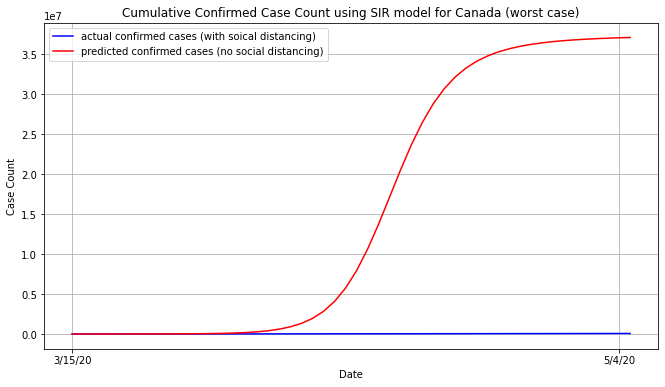

predicted cases on 5/5/20: 37060970.12708933
actual cases on 5/5/20: 63215


In [26]:
N = 3.76e7 # total population in Canada
inf0 = 252 # number of infected people on 03/15/20
rec0 = 8 #  number of recovery people on 03/15/20
sus0 = N - inf0- rec0 # number of suspectible people

ydata = df_seg.transpose().values.reshape(1,-1)[0] #actual confirmed cases
xdata = np.arange(1, len(ydata)+1)

#Worst Case 
beta = 0.5 #high contact rate, no social distancing
gamma = 0.1 #low recovery rate, distressed medical system
y0 = (sus0,inf0,rec0)
sus_w,inf_w,rec_w = integrate.odeint(sir,y0,xdata,args=(beta,gamma)).T # predicted S,I,R values

confirm_worst = inf_w+rec_w # total confirmed cases
fig = plt.figure(figsize=(11,6))
ax = fig.add_subplot(111)
date = df_seg.columns
ax.plot(date,ydata, 'b', label='actual confirmed cases (with soical distancing)');
ax.plot(date,confirm_worst, 'r', label='predicted confirmed cases (no social distancing)');
ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
ax.legend(loc='best')
#ax.set_ylim([0, 100000])
plt.title('Cumulative Confirmed Case Count using SIR model for Canada (worst case)')
plt.ylabel("Case Count")
plt.xlabel("Date")
ax.grid(True)
plt.show()
print('predicted cases on 5/5/20: {}'.format(confirm_worst[-1]))
print('actual cases on 5/5/20: {}'.format(ydata[-1]))

### The best case assumes better social distancing than reality, so we also plot the best case to see the difference.

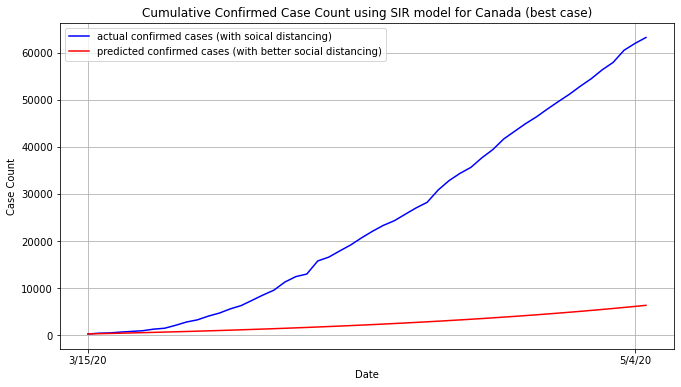

predicted cases on 5/5/20: 6336.18743491177
actual cases on 5/5/20: 63215


In [27]:
N = 3.76e7 # total population in Canada
inf0 = 252 # number of infected people on 03/15/20
rec0 = 8 #  number of recovery people on 03/15/20
sus0 = N - inf0- rec0 # number of suspectible people

ydata = df_seg.transpose().values.reshape(1,-1)[0] #actual confirmed cases
xdata = np.arange(1, len(ydata)+1)

#best Case 
beta = 0.2 #lower contact rate, better social distancing
gamma = 0.17 #higher recovery rate, better medical system
y0 = (sus0,inf0,rec0)
sus_b,inf_b,rec_b = integrate.odeint(sir,y0,xdata,args=(beta,gamma)).T # predicted S,I,R values

confirm_best = inf_b+rec_b # total confirmed cases
fig = plt.figure(figsize=(11,6))
ax = fig.add_subplot(111)
date = df_seg.columns
ax.plot(date,ydata, 'b', label='actual confirmed cases (with soical distancing)');
ax.plot(date,confirm_best, 'r', label='predicted confirmed cases (with better social distancing)');
ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
ax.legend(loc='best')
#ax.set_ylim([0, 100000])
plt.title('Cumulative Confirmed Case Count using SIR model for Canada (best case)')
plt.ylabel("Case Count")
plt.xlabel("Date")
ax.grid(True)
plt.show()
print('predicted cases on 5/5/20: {}'.format(confirm_best[-1]))
print('actual cases on 5/5/20: {}'.format(ydata[-1]))

### We can see that if there was no social distancing, with a beta over gamma ratio of 5, the predicted curve would go significantly higher than the actual curve, and most of the population in Canada would be infected by 5/5/2020. And if there was a stronger social distancing than reality, the predicted curve would go much lower than the actual curve, and it ended up with only around tenth of the actual cases number on 5/5/2020. This means social distancing really matters in restricting the spread of Covid-19.

## 5.0 Guidance to tackle Covid-19

### From the worst and best cases, we know that beta over gamma raito is the key factor affecting the spread of covid-19. If the ratio is high, such as 5, the infection will grow throughout the population very soon. If the ratio is low, (i.e. close to 1), the infection will grow very slowly. If the ratio is less than 1 (not shown in the report), the infection will quickly die out since people are healing faster than they are spreading it.  So we need to decrease beta and increase gamma to lower the ratio, which consequently flattens the curve and retricts the spread of covid.
### From the base-case, which is the combination of the worst and best cases, we can see that the actions should be taken as soon as possible. Even if the government takes actions 7 days later, the curve will eventually go up and becomes very difficult to be flattened.
### From part 4 we know that social distancing is crucial in restricting the spread of Covid. This is because social distancing greatly reduces beta(contact rate) and thereby lowers the ratio. Now Canda is in the second wave, so the government should impose policies such as lockdown and stay home order which encourage social distancing, and the action should also be taken immediately to flatten the curve. 